# Importing Emcee and running a test code

In [1]:
import numpy as np
import emcee

print('emcee version is',emcee.__version__)

#sample code
def log_prob(x, ivar):
    return -0.5 * np.sum(ivar * x ** 2)

ndim, nwalkers = 5, 100  #can change the number of dimensions here
ivar = 1. / np.random.rand(ndim)
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[ivar])
sampler_run = sampler.run_mcmc(p0, 10000);
#print(sampler_run)
#you can un-comment the above line to see the output of emcee; it is pretty long so that's why it's commented out.

#sample code end

emcee version is 3.1.6


# Using Emcee to sample from a high dimensional Gaussian density function

The mean acceptance fraction is 0.5952
the mean autocoorelation time is 46.0962 steps

from the below plot, we can see how emcee is sampling from all the different directions in the space. We can see it distinguish
      between each direction, as there was a different mean defined for each direction, and a different mean is there for each histogram



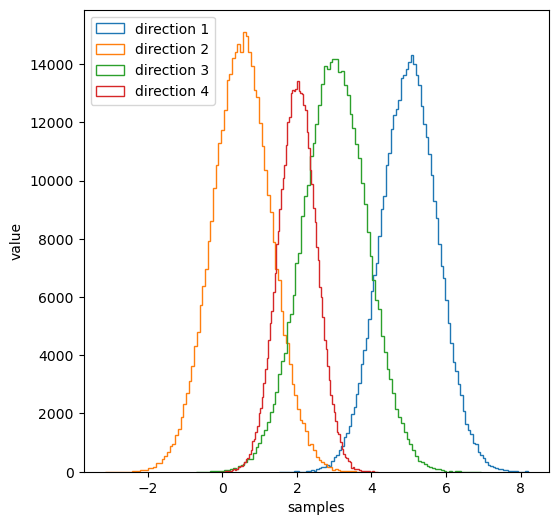

In [2]:
# defining our log probability distribution
def log_prob(x, mean, covar):
    diff = x - mean
    return -1 * np.dot(diff, np.linalg.solve(covar, diff))
    # This value of x represents the position of a single "walker"

#number of dimensions
ndim = 4

#setting up the random number generator
np.random.seed(1234)
means = [5, 0.5, 3, 2]

#setting up the covariance
covar = 1 - np.random.rand(ndim**2).reshape((ndim,ndim))

#np.triu finds the upper triangle of an array; np.tril would find the lower triangle of an array.
covar = np.triu(covar)
covar += covar.T - np.diag(covar.diagonal())
covar = np.dot(covar, covar)

#setting up the "walkers"
nwalkers = 40
#setting up starting points for the walkers
p0 = np.random.rand(nwalkers, ndim)

#running the Emcee sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, covar])

state = sampler.run_mcmc(p0, 100)
sampler.reset()
sampler.run_mcmc(state, 10000);
samples = sampler.get_chain(flat=True);

#generating a histogram for each direction in the 4D space.
import matplotlib.pyplot as plt

fig, ax = plt.subplots( figsize=(6,6))
ax.hist(samples[:,0], 100, histtype='step', label = 'direction 1')
ax.hist(samples[:,1], 100, histtype='step', label = 'direction 2')
ax.hist(samples[:,2], 100, histtype='step', label = 'direction 3')
ax.hist(samples[:,3], 100, histtype='step', label = 'direction 4')

ax.set_xlabel('samples')
ax.set_ylabel('value')

ax.legend()

#it's generally a good idea to check the mean acceptance fraction and mean autocoorelation time to determine if the sampling went well.
print('The mean acceptance fraction is {0:.4f}'.format(np.mean(sampler.acceptance_fraction)))
print('the mean autocoorelation time is {0:.4f} steps'.format(np.mean(sampler.get_autocorr_time())))

print('''\nfrom the below plot, we can see how emcee is sampling from all the different directions in the space. We can see it distinguish
      between each direction, as there was a different mean defined for each direction, and a different mean is there for each histogram\n''')

# Using Emcee to estimate uncertainties on a dataset

Tere we will say that we have a dataset where we think the reported uncertainties are too small. Then, we will try and estimate the true uncertainties on the data using emcee. 

This will take a bit to get to the part where emcee comes into play, but I think it is worth the wait so bear with me through the early part of the next code cell please. 

I will also use corner here to visualize what emcee finds.

a (least squares) = -0.279 ± 0.046
b (least squares) = -6.918 ± 0.447
c (least squares) = 13.091 ± 0.789

Note how the least-squares estimate is not that close to the true function. It's values for a, b, and c are all off by very large
amounts compared to the true values and reported uncertainties. This isn't unsurprising given that we intentionally underestimated
the true uncertainties, but we will see that a "maximum likelyhood" estimation can do better.

Maximum likelihood estimates:
a = -1.259
b = 1.598
c= 3.668
f = 0.423
These Maximum Likelyhood estimates are much better.

The second figure is a corner plot illustrating the best fit values for each parameter, the covariances between them, 
and where each parametersits compared to it's best value if we didn't care about any other parameters, and where it
sits compared to some confidence intervals



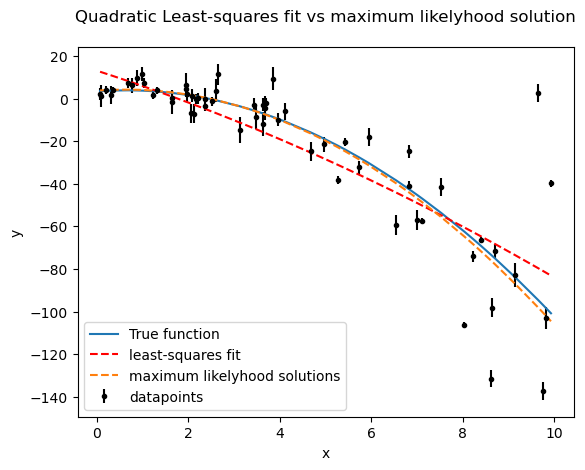

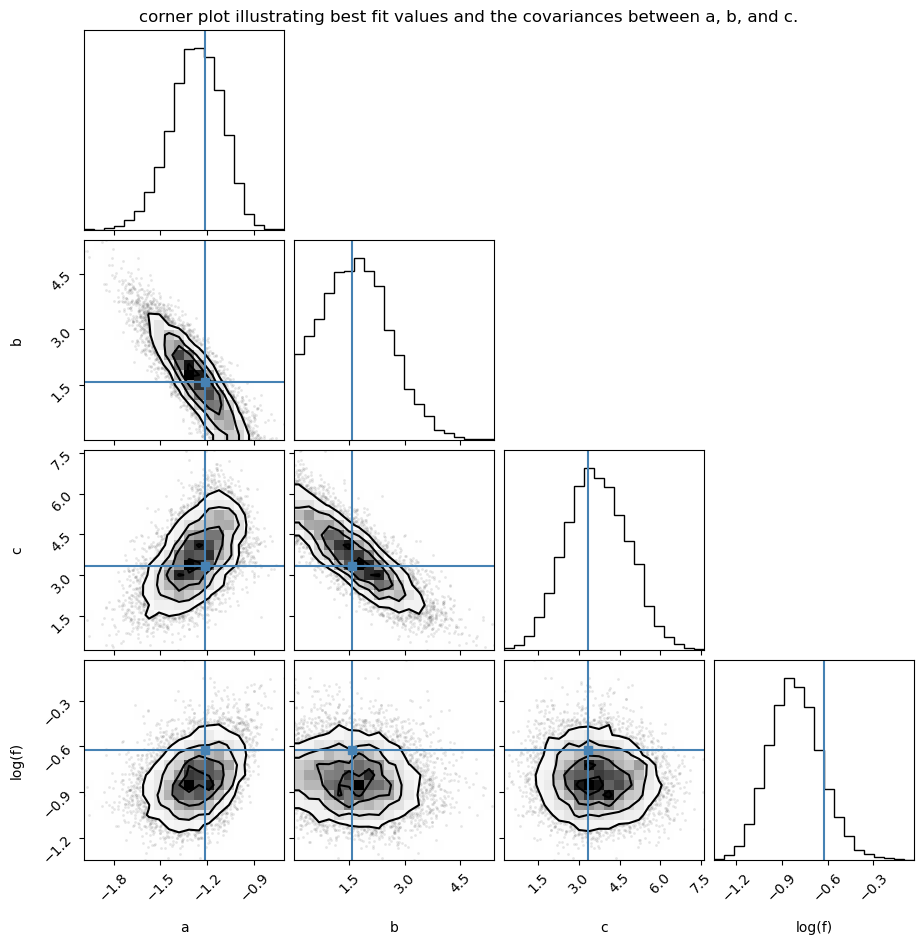

In [3]:
#Minimize is needed to find Emcee's solution
from scipy.optimize import minimize
import corner

#resetting the seed
np.random.seed(1234567)

#choosing the true values for the parameters for the sake of this demo
#model will be y = ax^2 + bx + c
a = -1.215
b = 1.574
c = 3.335
underestimation_fraction = 0.534

#creating hypothetical data from these parameters plus some error.
#we are assuming for this dataset that we underestimated the true uncertainties.

n_points = 60
x_vals = np.sort(10*np.random.rand(n_points))
y_true = a * x_vals**2 + b * x_vals + c
y_error = 1 + 5 * np.random.rand(n_points)
y_vals = y_true + np.abs(underestimation_fraction * y_true) * np.random.randn(n_points)
y_vals += y_error * np.random.randn(n_points)

#Standard Least Squares solution. 
A = np.vander(x_vals, 3)
C = np.diag(y_error * y_error)
ATA = np.dot(A.T, A / (y_error**2)[:, None])
covar = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y_vals / y_error**2))

#printing the least squares outputs
print("a (least squares) = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(covar[0, 0])))
print("b (least squares) = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(covar[1, 1])))
print("c (least squares) = {0:.3f} ± {1:.3f}".format(w[2], np.sqrt(covar[2, 2])))

print('''\nNote how the least-squares estimate is not that close to the true function. It's values for a, b, and c are all off by very large
amounts compared to the true values and reported uncertainties. This isn't unsurprising given that we intentionally underestimated
the true uncertainties, but we will see that a "maximum likelyhood" estimation can do better.\n''')

#now, to find a better solution; the "maximum likelyhood" estimation.
def log_likelihood(theta, x, y, y_error):
    a_fit, b_fit, c_fit, log_f = theta
    model = a_fit*x**2 + b_fit*x + c_fit
    sigma2 = y_error**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

nll = lambda *args: -log_likelihood(*args)
initial = np.array([a, b, c, np.log(underestimation_fraction)]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(x_vals, y_vals, y_error))
a_ML, b_ML, c_ML, log_fraction_ML = soln.x

#printing the maximum likelyhood solutions
print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(a_ML))
print("b = {0:.3f}".format(b_ML))
print("c= {0:.3f}".format(c_ML))
print("f = {0:.3f}".format(np.exp(log_fraction_ML)))

print('These Maximum Likelyhood estimates are much better.')

#generating a plot
fig, ax = plt.subplots()
#plotting the datapoints with underestimated errorbars
ax.errorbar(x_vals, y_vals, yerr=y_error, fmt=".k", capsize=0,label='datapoints')
#plotting the true function
ax.plot(x_vals, a*x_vals**2 + b*x_vals + c,label='True function')
#plotting the least-squares estimate
ax.plot(x_vals, np.dot(np.vander(x_vals, 3), w), c='r', label='least-squares fit',ls='--')
#plotting the maximum likelyhood function
ax.plot(x_vals, np.dot(np.vander(x_vals, 3), [a_ML, b_ML, c_ML]), label='maximum likelyhood solutions',ls='--')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('Quadratic Least-squares fit vs maximum likelyhood solution\n')

#Now, to the part whcih uses Emcee: Estimating these errors.


def log_prior(theta):
    a, b, c, log_f = theta
    if -5.0 < a < 0.5 and 0.0 < b < 10.0 and 0 < c < 10 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = soln.x + 1e-4 * np.random.randn(45, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_vals, y_vals, y_error))
sampler.run_mcmc(pos, 2500);

#it is generally good to throw out a few of the early samples, which is what I do below
samples_filtered = sampler.get_chain(discard=100, thin=15, flat=True)

fig2 = corner.corner(samples_filtered, labels=['a', 'b', 'c', 'log(f)'], truths=[a, b, c, np.log(underestimation_fraction)]);
fig2.suptitle('corner plot illustrating best fit values and the covariances between a, b, and c.')

print('''\nThe second figure is a corner plot illustrating the best fit values for each parameter, the covariances between them, 
and where each parametersits compared to it's best value if we didn't care about any other parameters, and where it
sits compared to some confidence intervals\n''')